# Прогнозирование уровня средней заработной платы в России

В файле записаны данные о заработной плате за каждый месяц с января 1993 по август 2016.

Необходимо проанализировать данные, подобрать для них оптимальную прогнозирующую модель в классе ARIMA и построить прогноз на каждый месяц на два года вперёд от конца данных.

In [14]:
%matplotlib inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product
import seaborn as sns

In [4]:
def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

## Визуальный анализ ряда

In [17]:
data = pd.read_csv('WAG_C_M.csv',';', index_col=['month'], parse_dates=['month'], dayfirst=True)

In [18]:
data.head()

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


In [19]:
data.columns = ['wage']

Text(0.5, 1.0, 'Average wage')

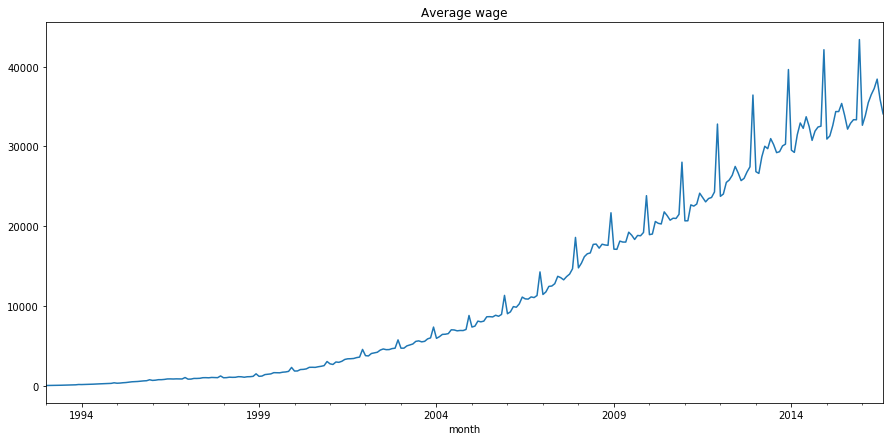

In [20]:
plt.figure(figsize=(15,7))
data['wage'].plot()
plt.title('Average wage')

Проверка стационарности и STL-декомпозиция ряда:

Критерий Дики-Фуллера: p=0.991850


<Figure size 1080x720 with 0 Axes>

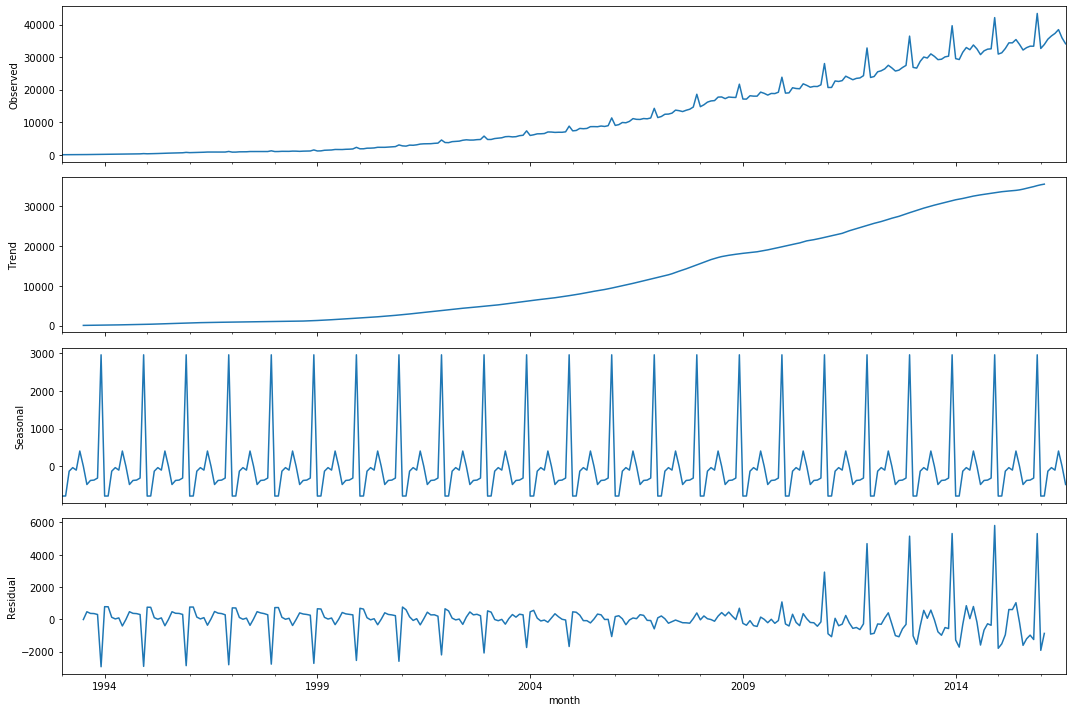

In [22]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data['wage']).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data['wage'])[1])

## Стабилизация дисперсии

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


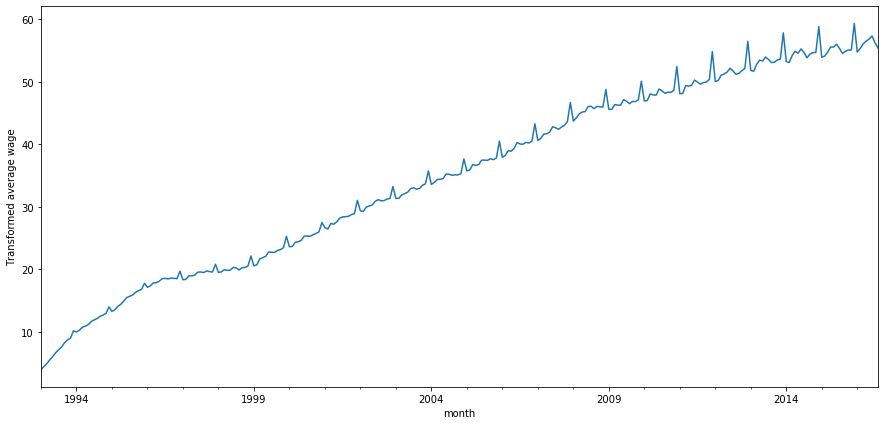

In [25]:
data['wage_box'], lmbda = stats.boxcox(data.wage)
plt.figure(figsize(15,7))
data['wage_box'].plot()
plt.ylabel('Transformed average wage')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data['wage_box'])[1])

## Стационарность

Критерий Дики-Фуллера не отвергает гипотезу нестационарности и визуально в данных виден тренд. Попробуем сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

Критерий Дики-Фуллера: p=0.014697


<Figure size 1080x720 with 0 Axes>

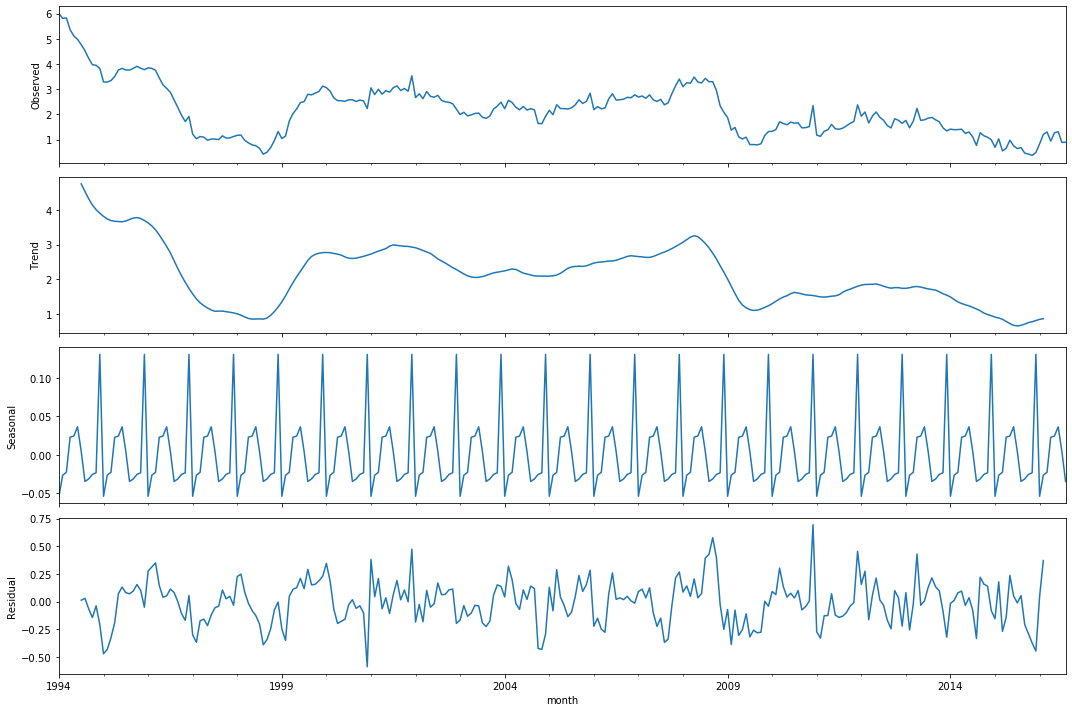

In [26]:
data['wage_box_diff'] = data['wage_box'] - data['wage_box'].shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data['wage_box_diff'][12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data['wage_box_diff'][12:])[1])

Критерий Дики-Фуллера отвергает гипотезу нестационарности, но полностью избавиться от тренда не удалось. Попробуем добавить ещё обычное дифференцирование:

Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

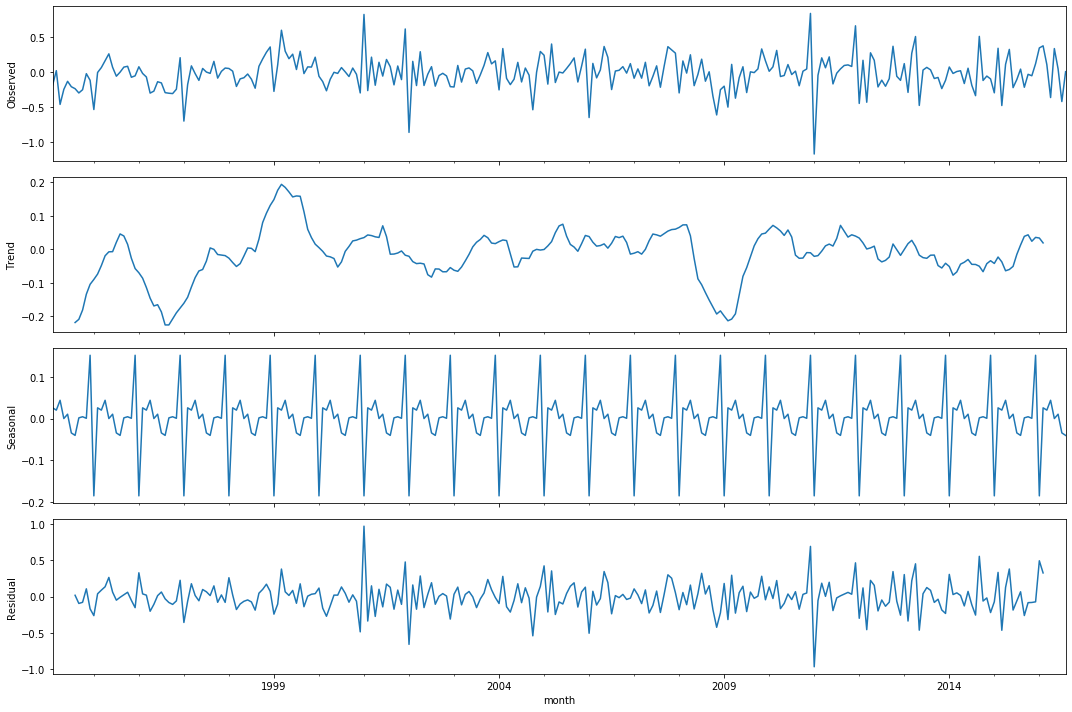

In [27]:
data['wage_box_diff2'] = data['wage_box_diff'] - data['wage_box_diff'].shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data['wage_box_diff2'][13:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data['wage_box_diff2'][13:])[1])

Гипотеза нестационарности отвергается, и визуально ряд выглядит лучше — тренда больше нет.

## Подбор модели

Посмотрим на ACF и PACF полученного ряда:

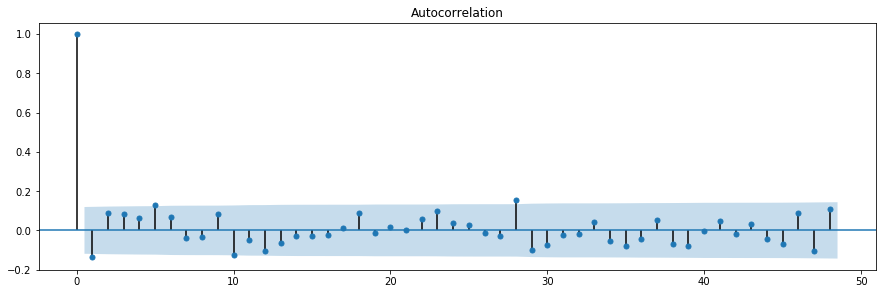

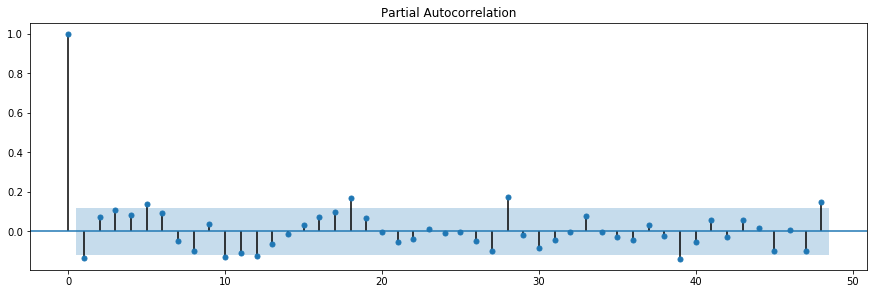

In [33]:
plt.figure(figsize(15,10))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data['wage_box_diff2'][13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data['wage_box_diff2'][13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

Выбор начальных приближений для p, q, P, Q

Q=0, q=1, P=1, p=1

In [38]:
Qs = range(0, 1)
qs = range(0, 2)
Ps = range(0, 2)
ps = range(0, 2)
D = 1
d = 1

In [39]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

8

In [40]:
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data.wage_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

In [41]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

     parameters       aic
5  (1, 0, 1, 0)  0.340521
3  (0, 1, 1, 0)  1.170768
7  (1, 1, 1, 0)  2.021911
4  (1, 0, 0, 0)  2.625709
2  (0, 1, 0, 0)  3.369832


Лучшая модель:

In [42]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                           wage_box   No. Observations:                  284
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                   2.830
Date:                            Wed, 10 Jun 2020   AIC                              0.341
Time:                                    15:37:00   BIC                             11.147
Sample:                                01-01-1993   HQIC                             4.679
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1488      0.046     -3.210      0.001      -0.240      -0.058
ar.S.L12      -0.1314      0.046   

Остатки модели:

Критерий Стьюдента: p=0.090793
Критерий Дики-Фуллера: p=0.000003


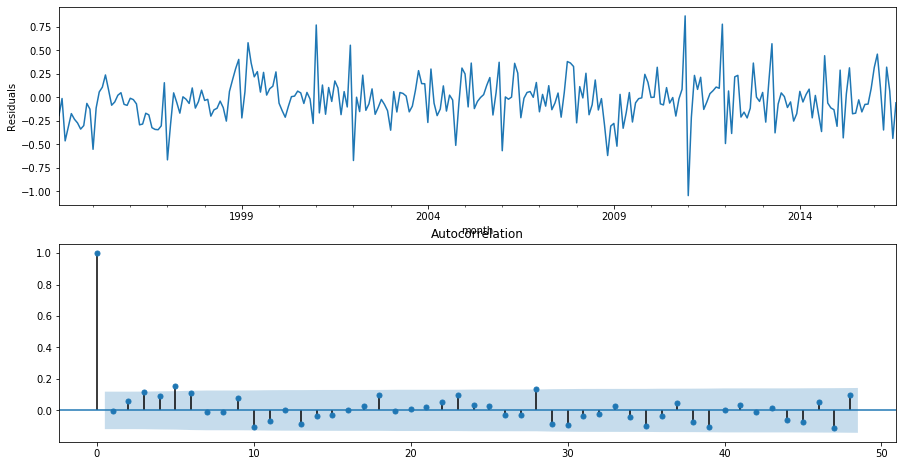

In [43]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel('Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой). Посмотрим, насколько хорошо модель описывает данные:

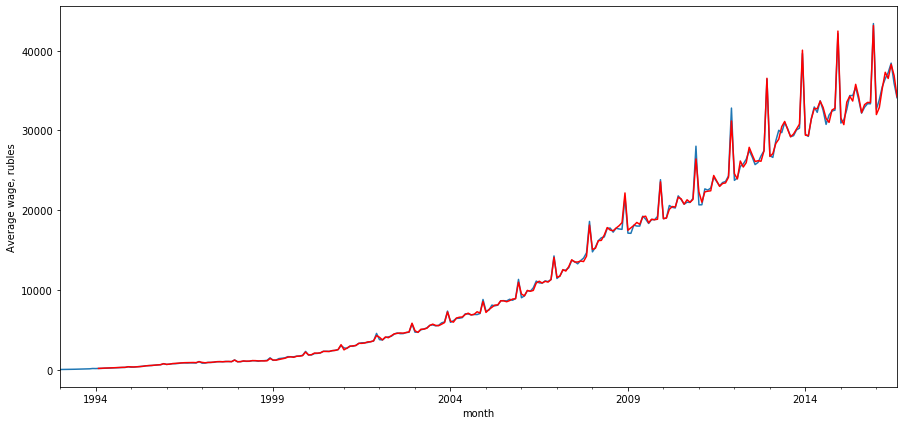

In [44]:
data['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
data.wage.plot()
data.model[13:].plot(color='r')
plt.ylabel('Average wage, rubles')
pylab.show()

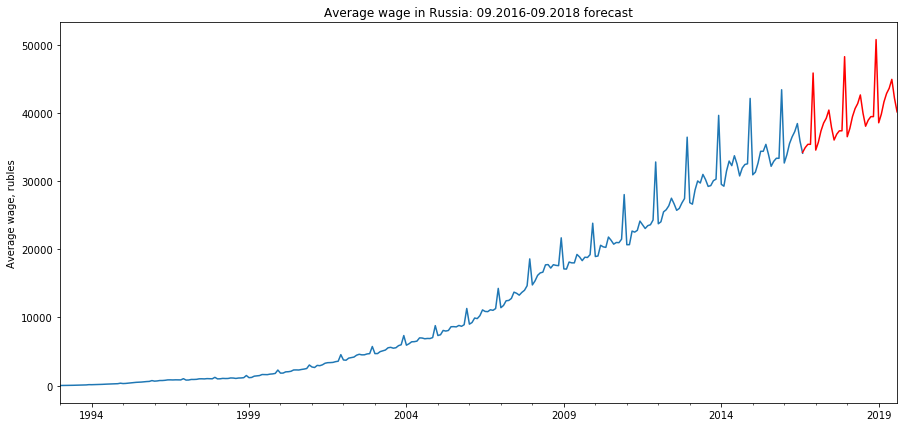

In [55]:
data2 = data[['wage']]
date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns=data2.columns)
data2 = pd.concat([data2, future])
data2['forecast'] = invboxcox(best_model.predict(start=283, end=283+36), lmbda)

plt.figure(figsize(15,7))
data2['wage'].plot()
data2['forecast'].plot(color='r')
plt.ylabel('Average wage, rubles')
plt.title('Average wage in Russia: 09.2016-09.2018 forecast')
pylab.show()